# Coinciding Event Count

The goal of this notebook is to count the number of times that an event occurs before, during, or after a designaged climate state. This notebook requires:
* event_finder.ipynb
* climate_state_finder.ipynb


## Make Selections

1. Make climate selections 

In [1]:
climate_variable = "Precipitation (total)"
climate_duration = "24"
climate_timescale = "monthly" 

2. Make event selections

In [2]:
event_variable = "Precipitation (total)"
event_duration = "1"
event_timescale = "daily" 
event_method = "1_in_10"

3. Select GWL 

In [3]:
gwl = "1.5"

4. Select type of integration 

In [4]:
# Matched up
# Event happens right after a climate state? 
# event happens within X {time} of climate state observed? 
event_climate_state_overlap_type = "during" # during, after, or before
event_climate_state_overlap_duration = 10 # some number MUST BE IN DAYS
event_climate_state_overlap_duration_units = "days"  
climate_state_direction = "positive" # positive, negative, either 

## Import Libraries

In [5]:
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

## Load Data

In [6]:
# start with climate 
clim_filename = (f'climate_state/climate_state_{climate_variable}_under_{gwl}gwl_with_{climate_duration}{climate_timescale}duration.nc'.replace(" ", "_"))
climData = xr.open_dataset(clim_filename)

In [7]:
# move to event 
event_filename = (f'event_finder/event_{event_variable}_under_{gwl}gwl_with_{event_method}_{event_duration}{event_timescale}duration.nc'.replace(" ", "_"))
eventData = xr.open_dataset(event_filename)

## Prepare Data

In [8]:
# resample climate data to hourly
if climate_timescale != "hourly":
    clim_hourly = climData.resample(time="1h").ffill()
else:
    clim_hourly=climData

In [9]:
# resample event data to hourly
if event_timescale != "hourly":
    event_hourly = eventData.resample(time="1h").ffill()
else:
    event_hourly=eventData

In [10]:
# remove unnecessary coordinates
event_hourly = event_hourly.drop_vars(["centered_year","spatial_ref",
                                       "Lambert_Conformal"])


In [11]:
# remove unnecessary coordinates
clim_hourly = clim_hourly.drop_vars(["climate_state_high",
                                     "climate_state_low"])

In [12]:
# rename precipitation
clim_hourly = clim_hourly.rename({"Precipitation (total)": "Climate Precipitation (total)"})
event_hourly = event_hourly.rename({"Precipitation (total)": "Event Precipitation (total)"})

## Merge

In [13]:
 # concat climate state and event 
final = xr.merge([event_hourly,clim_hourly],compat="override")

In [14]:
# convert to data frame for easy facet plotting
mergedDF = final.to_dataframe()

## Initial plotting 

IOStream.flush timed out


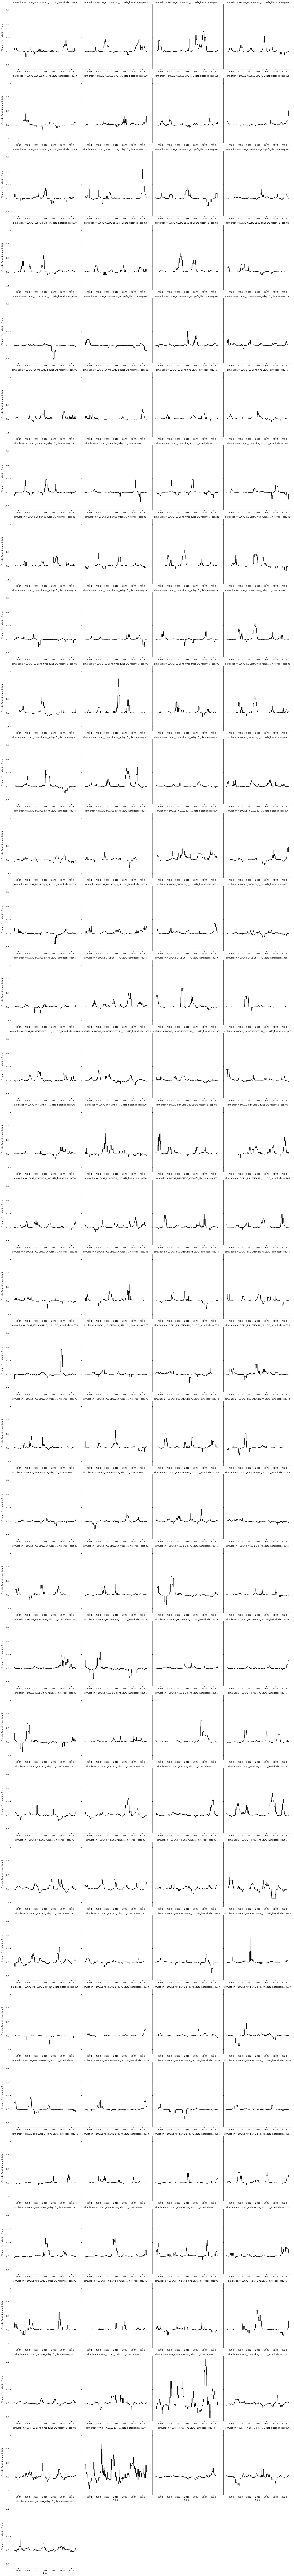

In [15]:
g1 = sns.relplot(
    data=mergedDF,
    x="time", y=f'Climate {climate_variable}',
    col="simulation",color="black",col_wrap=4,
    kind="line", 
    height=5, aspect=1, facet_kws=dict(sharex=False)
)


In [16]:
def test (data, **kws):
    ax = plt.gca()
    ax.axvline(0, ls='--',color="black")
g1.map_dataframe(test)

In [ ]:
# create a plot that simply overlays the climate states with the events 
def climate(data, **kws):
    ax = plt.gca()
    ax.axhline(0, ls='--',color="black")
    ax.fill_between(data.time,data[f'Climate {climate_variable}'],where=data.climate_state_hit == 1,facecolor='maroon',alpha=.5)
    ax.fill_between(data.time,data[f'Climate {climate_variable}'],where=data.climate_state_hit == -1,facecolor='darkblue',alpha=.5)
def event(data, **kws):
    ax = plt.gca()
    ax.axvline(data.time[data.event_hit == 1], ls='--',color="black")
g1 = sns.relplot(
    data=mergedDF,
    x="time", y=f'Climate {climate_variable}',
    col="simulation",color="black",col_wrap=4,
    kind="line", 
    height=5, aspect=1, facet_kws=dict(sharex=False)
)
g1.map_dataframe(climate)

In [ ]:
def event(data, **kws):
    ax = plt.gca()
    ax.axvline(data["time"].iloc[5], ls='--',color="black")

In [ ]:
g1.map_dataframe(event)

## Frequency Count

For a given climate state and see if the event occurred within, after, or before

In [ ]:
climate_state_direction = "either"

In [ ]:
# create a new variable for coindicing events (1 is a hit; 0 is a miss) 
final_coinciding_event_count = np.zeros(final["simulation"].values.shape)
for isim in range(final["simulation"].values.shape[0]):
    # pull out climate hits
    climate_hits = final["climate_state_hit"][:,isim]
    # pull out event hits
    event_hits = final["event_hit"][:,isim]
    
    # depending on desired climate state -- Positive
    if (climate_state_direction == "positive") & (len(np.where(climate_hits==1)[0]) > 0):
        # find all occurrences of one
        goodIndex = np.where(climate_hits == 1)[0]
        # determine the number of times the simulation is in this climate state
        diffStates = np.diff(goodIndex)
        newStates = (np.where(diffStates > 1)[0])+1
        numStates = len(newStates)+1
        # create an index with start states
        startState = np.append(np.array(goodIndex[0]),goodIndex[newStates])
        for istate in range(numStates):
            if istate == (numStates-1):
                currentEndState = goodIndex[len(goodIndex)-1]
            else:
                currentEndState = goodIndex[newStates[istate-1]-1]
            if istate ==0:
                endState = np.array([currentEndState])
            else:
                endState = np.append(endState,currentEndState)
        # create a coindicing events array to keep track of counts
        coincidingEvents = np.zeros(numStates)
        # now loop through each state to look if events occur
        for istate in range(numStates):
            ### depending on the type overlap - look for events
            # If during
            if event_climate_state_overlap_type == "during":
                # pull out events durign cliamte state
                temp_events = event_hits[startState[istate]:endState[istate]]
                # find if there were any events
                goodEventHits = np.where(temp_events == 1)
                # if there are events - then count
                if len(goodEventHits) > 0:
                    coincidingEvents[istate] = 1
            # If after
            if event_climate_state_overlap_type == "after":
                # pull out events durign cliamte state
                temp_events = event_hits[endState[istate]:endState[istate]+event_climate_state_overlap_duration*24]
                # find if there were any events
                goodEventHits = np.where(temp_events == 1)
                # if there are events - then count
                if len(goodEventHits) > 0:
                    coincidingEvents[istate] = 1
            # If before
            if event_climate_state_overlap_type == "before":
                # pull out events durign cliamte state
                temp_events = event_hits[startState[istate]-event_climate_state_overlap_duration*24:startState[istate]]
                # find if there were any events
                goodEventHits = np.where(temp_events == 1)
                # if there are events - then count
                if len(goodEventHits) > 0:
                    coincidingEvents[istate] = 1
        # based on this - save the number of coinciding events for this simulation
        final_coinciding_event_count[isim] = coincidingEvents.sum()

    # depending on desired climate state -- Negative
    if (climate_state_direction == "negative") & (len(np.where(climate_hits==-1)[0]) > 0):
        # find all occurrences of -1 
        goodIndex = np.where(climate_hits == -1)[0]
        # determine the number of times the simulation is in this climate state
        diffStates = np.diff(goodIndex)
        newStates = (np.where(diffStates > 1)[0])+1
        numStates = len(newStates)+1
        # create an index with start states
        startState = np.append(np.array(goodIndex[0]),goodIndex[newStates])
        for istate in range(numStates):
            if istate == (numStates-1):
                currentEndState = goodIndex[len(goodIndex)-1]
            else:
                currentEndState = goodIndex[newStates[istate-1]-1]
            if istate ==0:
                endState = np.array([currentEndState])
            else:
                endState = np.append(endState,currentEndState)
        # create a coindicing events array to keep track of counts
        coincidingEvents = np.zeros(numStates)
        # now loop through each state to look if events occur
        for istate in range(numStates):
            ### depending on the type overlap - look for events
            # If during
            if event_climate_state_overlap_type == "during":
                # pull out events durign cliamte state
                temp_events = event_hits[startState[istate]:endState[istate]]
                # find if there were any events
                goodEventHits = np.where(temp_events == 1)
                # if there are events - then count
                if len(goodEventHits) > 0:
                    coincidingEvents[istate] = 1
            # If after
            if event_climate_state_overlap_type == "after":
                # pull out events durign cliamte state
                temp_events = event_hits[endState[istate]:endState[istate]+event_climate_state_overlap_duration*24]
                # find if there were any events
                goodEventHits = np.where(temp_events == 1)
                # if there are events - then count
                if len(goodEventHits) > 0:
                    coincidingEvents[istate] = 1
            # If before
            if event_climate_state_overlap_type == "before":
                # pull out events durign cliamte state
                temp_events = event_hits[startState[istate]-event_climate_state_overlap_duration*24:startState[istate]]
                # find if there were any events
                goodEventHits = np.where(temp_events == 1)
                # if there are events - then count
                if len(goodEventHits) > 0:
                    coincidingEvents[istate] = 1
        # based on this - save the number of coinciding events for this simulation
        final_coinciding_event_count[isim] = coincidingEvents.sum()

    # depending on desired climate state -- either
    if (climate_state_direction == "either") & (len(np.where(climate_hits !=0 )[0]) > 0):
        # find all occurrences of either 1 or -1
        goodIndex = np.where(climate_hits != 0)[0]
        # determine the number of times the simulation is in this climate state
        diffStates = np.diff(goodIndex)
        newStates = (np.where(diffStates > 1)[0])+1
        numStates = len(newStates)+1
        # create an index with start states
        startState = np.append(np.array(goodIndex[0]),goodIndex[newStates])
        for istate in range(numStates):
            if istate == (numStates-1):
                currentEndState = goodIndex[len(goodIndex)-1]
            else:
                currentEndState = goodIndex[newStates[istate-1]-1]
            if istate ==0:
                endState = np.array([currentEndState])
            else:
                endState = np.append(endState,currentEndState)
        # create a coindicing events array to keep track of counts
        coincidingEvents = np.zeros(numStates)
        # now loop through each state to look if events occur
        for istate in range(numStates):
            ### depending on the type overlap - look for events
            # If during
            if event_climate_state_overlap_type == "during":
                # pull out events durign cliamte state
                temp_events = event_hits[startState[istate]:endState[istate]]
                # find if there were any events
                goodEventHits = np.where(temp_events == 1)
                # if there are events - then count
                if len(goodEventHits) > 0:
                    coincidingEvents[istate] = 1
            # If after
            if event_climate_state_overlap_type == "after":
                # pull out events durign cliamte state
                temp_events = event_hits[endState[istate]:endState[istate]+event_climate_state_overlap_duration*24]
                # find if there were any events
                goodEventHits = np.where(temp_events == 1)
                # if there are events - then count
                if len(goodEventHits) > 0:
                    coincidingEvents[istate] = 1
            # If before
            if event_climate_state_overlap_type == "before":
                # pull out events durign cliamte state
                temp_events = event_hits[startState[istate]-event_climate_state_overlap_duration*24:startState[istate]]
                # find if there were any events
                goodEventHits = np.where(temp_events == 1)
                # if there are events - then count
                if len(goodEventHits) > 0:
                    coincidingEvents[istate] = 1
        # based on this - save the number of coinciding events for this simulation
        final_coinciding_event_count[isim] = coincidingEvents.sum()        

## Save Data

In [ ]:
# create a directory for saving everything, if it does not exist already
folder_path = "coinciding_events"  # Replace with your desired folder path

try:
    os.makedirs(folder_path, exist_ok=True)
    print(f"Folder '{folder_path}' created successfully or already exists.")
except OSError as e:
    print(f"Error creating folder '{folder_path}': {e}")

In [ ]:
# prep array for saving
final_count = xr.DataArray(final_coinciding_event_count,
                           coords={'simulation':final["simulation"],
                                  'gwl':gwl,'event_variable':event_variable,
                                   'event_duration':f'{event_duration}_{event_timescale}',
                                   'event_type':event_method,
                                   'climate_variable':climate_variable,
                                   'climate_duration':f'{climate_duration}_{climate_timescale}',
                                   'climate_direction':climate_state_direction,
                                   'overlap': event_climate_state_overlap_type,
                                   'overlap_duration': f'{event_climate_state_overlap_duration}_{event_climate_state_overlap_duration_units}'
                                  },
                            dims='simulation')

In [ ]:
# save count for summary stats/plotting later 
final_count.to_netcdf(f'coinciding_events/coinciding_event_count_for_climate_state_{climate_state_direction}_'\
    f'{climate_variable}_{climate_duration}_'\
    f'{climate_timescale}_with_{event_variable}_{event_duration}_{event_timescale}_'\
    f'{event_method}_event_{event_climate_state_overlap_type}_{event_climate_state_overlap_duration}_'\
    f'{event_climate_state_overlap_duration_units}.nc'
    .replace(" ", "_"))